In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from pathlib import Path 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

In [ ]:
NOISY_PATH = "./Noisy_small"
REF_PATH = "./Ref_small"
SMALL_PATH = "./Small"

source = os.listdir(NOISY_PATH)
destination = os.listdir(REF_PATH)
for file in source:
    fullFileName = Path(file).name
    fileName = fullFileName.split('.')[0]
    if(int(fileName)%10 != 0 and os.path.exists(NOISY_PATH+"/"+file)):
        os.remove(NOISY_PATH+"/"+file)
        os.remove(REF_PATH+"/"+file)

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.FiveCrop(128)])}

noisy_Images = {x: datasets.ImageFolder(".//Noisy_small//",data_transforms[x]) for x in ['train']}
ref_Images = {x: datasets.ImageFolder(".//Ref_Small//",data_transforms[x]) for x in ['train']}
noisyIter = iter(noisy_Images['train'])
refIter = iter(ref_Images)

In [17]:
k = 0
for i in range(75):
    noisyPatches,dummy = noisy_Images['train'][i]
    refPatches,dummy = ref_Images['train'][i]
    for j in range(5):
        noisyPatches[j].save(".//Noisy_Patches//"+str(k)+".png","PNG")
        refPatches[j].save(".//Ref_Patches//"+str(k)+".png","PNG")
        k+=1

In [3]:
patchTransform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

noisyPatches = datasets.ImageFolder(".//Noisy_Patches",patchTransform)
refPatches = datasets.ImageFolder(".//Ref_Patches",patchTransform)

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.figure(figsize=(50,150))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

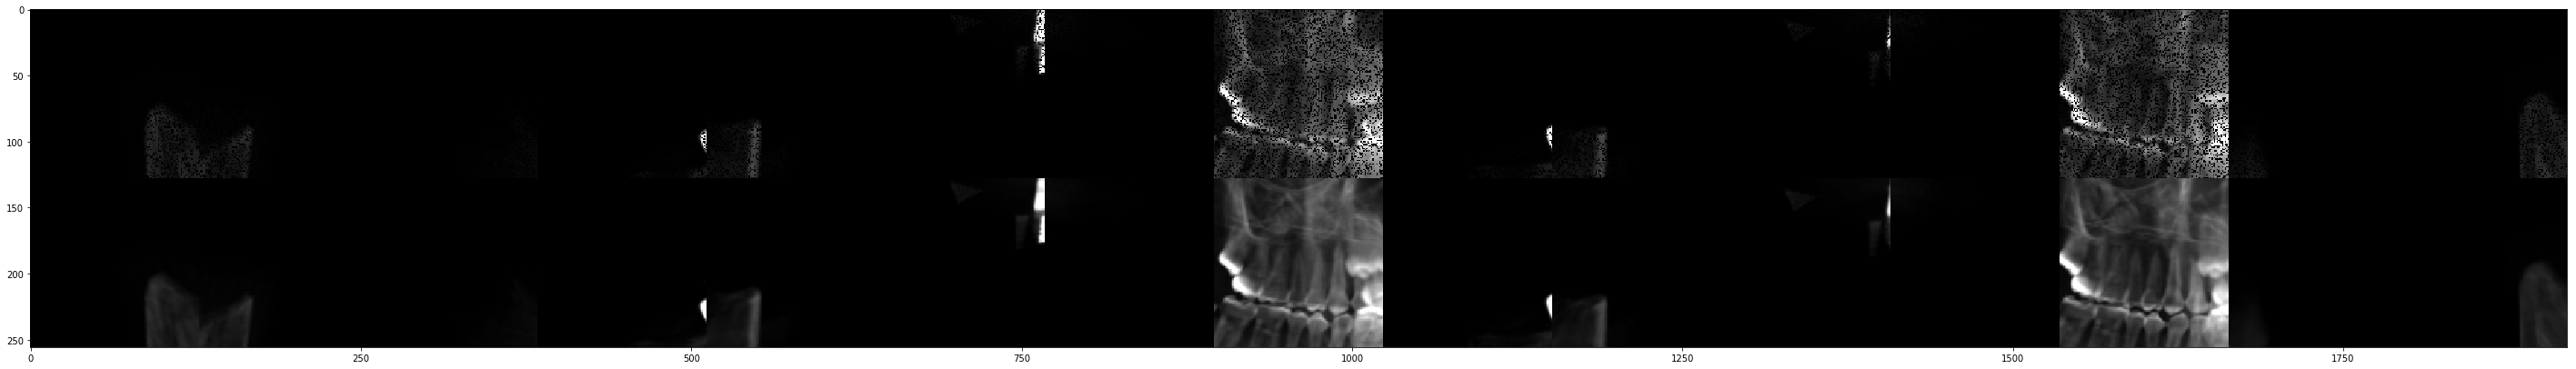

In [7]:
imgCount = 25
output2 = []
temp2 = None
for i in range(15):
    output = []
    output.append(noisyPatches[i][0])
    output.append(refPatches[i][0])
    temp = torch.cat(output,dim=1)
    output2.append(temp)

imshow(torch.cat(output2,dim=2))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 3, 3,stride=1, padding=1)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3,stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3,stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, 3,stride=1, padding=1)
        self.conv5 = nn.Conv2d(32,3, 3,stride=1, padding=1)
        
          
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.tanh(x)
        return x

In [13]:
net = Net()
net = net.cuda()
criterion = torch.nn.L1Loss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [14]:
indexes = [x for x in range(375)]
shuffle(indexes)
Val = indexes[0:75]
Train = indexes[100:]
Test = indexes[75:100]
len(Val),len(Train),len(Test),len(Val)+len(Train)+len(Test)

(75, 275, 25, 375)

In [15]:
NO_OF_EPOCH = 15
trainLoss = []
ValLoss = []
totalIter = 0

for _ in range(NO_OF_EPOCH):
    shuffle(Train)
    for trainIndex in Train:
        noisy,ref = noisyPatches[trainIndex][0],refPatches[trainIndex][0]
        
        noisy = noisy.cuda()
        ref = ref.cuda()

        optimizer.zero_grad()
        output = net(noisy.unsqueeze(0))
        loss = criterion(output, ref.unsqueeze(0))
        loss.backward()
        optimizer.step()
        
        trainLoss.append(loss.item())
        if(totalIter%50 == 0):
            with torch.no_grad():
                totalValLoss = 0.0
                for valIndex in Val:
                    noisyVal,refVal = noisyPatches[valIndex][0],refPatches[valIndex][0]
                    noisyVal = noisyVal.cuda()
                    refVal = refVal.cuda()
                    output = net(noisyVal.unsqueeze(0))
                    totalValLoss += criterion(output, refVal.unsqueeze(0))
                print("TotalIter:"+str(totalIter)+"TotalLoss:"+str(totalValLoss.item()))
                ValLoss.append(totalValLoss.item())
        totalIter +=1
        

TotalIter:0TotalLoss:67.33000946044922
TotalIter:50TotalLoss:66.0074462890625
TotalIter:100TotalLoss:65.80555725097656
TotalIter:150TotalLoss:65.63397979736328
TotalIter:200TotalLoss:65.56476593017578
TotalIter:250TotalLoss:65.54499816894531
TotalIter:300TotalLoss:65.5356216430664
TotalIter:350TotalLoss:65.53128051757812
TotalIter:400TotalLoss:65.52287292480469
TotalIter:450TotalLoss:65.51490020751953
TotalIter:500TotalLoss:65.51111602783203
TotalIter:550TotalLoss:65.5044937133789
TotalIter:600TotalLoss:65.5106430053711
TotalIter:650TotalLoss:65.49860382080078
TotalIter:700TotalLoss:65.49230194091797
TotalIter:750TotalLoss:65.48938751220703
TotalIter:800TotalLoss:65.48463439941406
TotalIter:850TotalLoss:65.52316284179688
TotalIter:900TotalLoss:65.48435974121094
TotalIter:950TotalLoss:65.48001098632812
TotalIter:1000TotalLoss:65.47648620605469
TotalIter:1050TotalLoss:65.47381591796875
TotalIter:1100TotalLoss:65.46914672851562
TotalIter:1150TotalLoss:65.4661865234375
TotalIter:1200TotalL

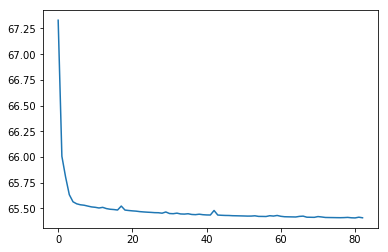

In [16]:
plt.plot(ValLoss)

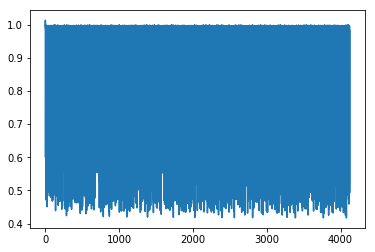

In [17]:
plt.plot(trainLoss)

In [18]:
output = output.squeeze(0)

In [19]:
output.shape

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


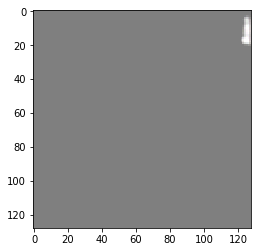

In [22]:
imshow(output.detach().cpu())

### Deeper CNN

In [27]:
net = Net2()
net = net.cuda()
criterion = torch.nn.L1Loss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [28]:
NO_OF_EPOCH = 15
trainLoss = []
ValLoss = []
totalIter = 0

for _ in range(NO_OF_EPOCH):
    shuffle(Train)
    for trainIndex in Train:
        noisy,ref = noisyPatches[trainIndex][0],refPatches[trainIndex][0]
        
        noisy = noisy.cuda()
        ref = ref.cuda()

        optimizer.zero_grad()
        output = net(noisy.unsqueeze(0))
        loss = criterion(output, ref.unsqueeze(0))
        loss.backward()
        optimizer.step()
        
        trainLoss.append(loss.item())
        if(totalIter%50 == 0):
            with torch.no_grad():
                totalValLoss = 0.0
                for valIndex in Val:
                    noisyVal,refVal = noisyPatches[valIndex][0],refPatches[valIndex][0]
                    noisyVal = noisyVal.cuda()
                    refVal = refVal.cuda()
                    output = net(noisyVal.unsqueeze(0))
                    totalValLoss += criterion(output, refVal.unsqueeze(0))
                print("TotalIter:"+str(totalIter)+"TotalLoss:"+str(totalValLoss.item()))
                ValLoss.append(totalValLoss.item())
        totalIter +=1

F:\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


TotalIter:0TotalLoss:66.10000610351562
TotalIter:50TotalLoss:65.9232177734375
TotalIter:100TotalLoss:65.58300018310547
TotalIter:150TotalLoss:65.57520294189453
TotalIter:200TotalLoss:65.62996673583984
TotalIter:250TotalLoss:65.55696868896484
TotalIter:300TotalLoss:65.5322265625
TotalIter:350TotalLoss:65.5196304321289
TotalIter:400TotalLoss:65.53357696533203
TotalIter:450TotalLoss:65.4940185546875
TotalIter:500TotalLoss:65.5012435913086
TotalIter:550TotalLoss:65.48548126220703
TotalIter:600TotalLoss:65.50999450683594
TotalIter:650TotalLoss:65.48015594482422
TotalIter:700TotalLoss:65.51068115234375
TotalIter:750TotalLoss:65.49735260009766
TotalIter:800TotalLoss:65.47566986083984
TotalIter:850TotalLoss:65.52588653564453
TotalIter:900TotalLoss:65.46495819091797
TotalIter:950TotalLoss:65.45858001708984
TotalIter:1000TotalLoss:65.45503234863281
TotalIter:1050TotalLoss:65.46253967285156
TotalIter:1100TotalLoss:65.45028686523438
TotalIter:1150TotalLoss:65.48303985595703
TotalIter:1200TotalLoss

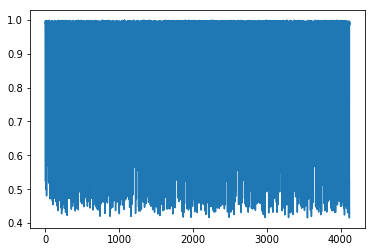

In [29]:
plt.plot(trainLoss)

In [31]:
output

torch.Size([1, 3, 128, 128])

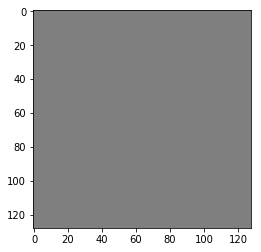

In [33]:
imshow(output.detach().cpu().squeeze(0))

### Skip Connections

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3,stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3,stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3,stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,stride=1, padding=1)
        self.conv7 = nn.Conv2d(128, 64, 3,stride=1, padding=1)
        self.conv8 = nn.Conv2d(64,32, 3,stride=1, padding=1) 
        self.conv9 = nn.Conv2d(32,3, 3,stride=1, padding=1)
        
          
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))
        x1 = F.relu(self.conv3(x1))
        x1 = F.relu(self.conv4(x1))
        x1 = F.relu(self.conv5(x1))
        x1 = F.relu(self.conv6(x1))
        x1 = F.relu(self.conv7(x1))
        x1 = F.relu(self.conv8(x1))
        x1 = F.relu(self.conv9(x1))
        x1 = x1+x
        x1 = F.tanh(x1)
        return x1

In [3]:
net = Net3()
net = net.cuda()
criterion = torch.nn.L1Loss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [4]:
NO_OF_EPOCH = 15
trainLoss = []
ValLoss = []
totalIter = 0

for _ in range(NO_OF_EPOCH):
    shuffle(Train)
    for trainIndex in Train:
        noisy,ref = noisyPatches[trainIndex][0],refPatches[trainIndex][0]
        
        noisy = noisy.cuda()
        ref = ref.cuda()

        optimizer.zero_grad()
        output = net(noisy.unsqueeze(0))
        loss = criterion(output, ref.unsqueeze(0))
        loss.backward()
        optimizer.step()
        
        trainLoss.append(loss.item())
        if(totalIter%50 == 0):
            with torch.no_grad():
                totalValLoss = 0.0
                for valIndex in Val:
                    noisyVal,refVal = noisyPatches[valIndex][0],refPatches[valIndex][0]
                    noisyVal = noisyVal.cuda()
                    refVal = refVal.cuda()
                    output = net(noisyVal.unsqueeze(0))
                    totalValLoss += criterion(output, refVal.unsqueeze(0))
                print("TotalIter:"+str(totalIter)+"TotalLoss:"+str(totalValLoss.item()))
                ValLoss.append(totalValLoss.item())
        totalIter +=1

NameError: name 'Train' is not defined

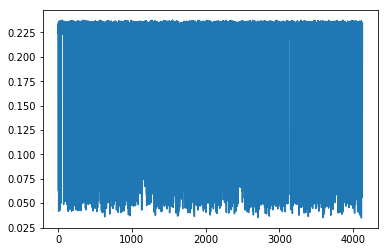

In [68]:
plt.plot(trainLoss)

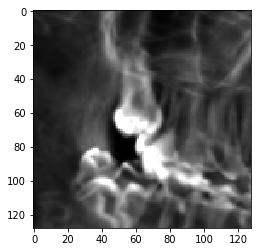

In [80]:
checkVal = 10
imshow(refPatches[Val[checkVal]][0].detach().cpu())

In [81]:
with torch.no_grad():
    noisyVal,refVal = noisyPatches[checkVal][0],refPatches[checkVal][0]
    noisyVal = noisyVal.cuda()
    refVal = refVal.cuda()
    output = net(noisyVal.unsqueeze(0))

F:\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


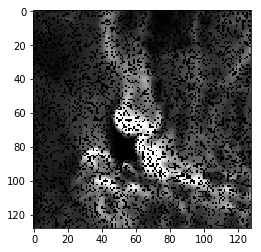

In [83]:
imshow(noisyPatches[Val[checkVal]][0].detach().cpu())

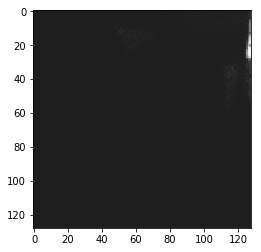

In [85]:
imshow(output.squeeze(0).detach().cpu())

### Better Dataset?

In [121]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(128)])}

noisy_Images = {x: datasets.ImageFolder(".//Noisy_small//",data_transforms[x]) for x in ['train']}
ref_Images = {x: datasets.ImageFolder(".//Ref_Small//",data_transforms[x]) for x in ['train']}
noisyIter = iter(noisy_Images['train'])
refIter = iter(ref_Images)

In [130]:
k = 0
for i in range(75):
    noisyPatches,dummy = noisy_Images['train'][i]
    refPatches,dummy = ref_Images['train'][i]
    noisyPatches.save(".//Noisy_Patches2//dummy//"+str(k)+".png","PNG")
    refPatches.save(".//Ref_Patches2//dummy//"+str(k)+".png","PNG")
    k+=1

In [2]:
TotalCount = 125
ValCount = int(0.20*125)
TrainCount = int(0.75*125)
TestCount = int(0.05*125)
indexes = [x for x in range(TotalCount)]
shuffle(indexes)
Train = indexes[0:TrainCount]
Val = indexes[TrainCount:TrainCount+ValCount]
Test = indexes[TrainCount+ValCount:]
len(Val),len(Train),len(Test),len(Val)+len(Train)+len(Test)

(25, 93, 7, 125)

In [5]:
net = Net3()
net = net.cuda()
criterion = torch.nn.L1Loss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [6]:
patchTransform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

noisyPatches = datasets.ImageFolder(".//Noisy_Patches2",patchTransform)
refPatches = datasets.ImageFolder(".//Ref_Patches2",patchTransform)

In [8]:
NO_OF_EPOCH = 65
trainLoss = []
ValLoss = []
totalIter = 0
lowestValLoss = 9999
for _ in range(NO_OF_EPOCH):
    shuffle(Train)
    totalTrainingLoss = 0.0
    for trainIndex in Train:
        noisy,ref = noisyPatches[trainIndex][0],refPatches[trainIndex][0]
        
        noisy = noisy.cuda()
        ref = ref.cuda()

        optimizer.zero_grad()
        output = net(noisy.unsqueeze(0))
        loss = criterion(output, ref.unsqueeze(0))
        loss.backward()
        optimizer.step()
        totalTrainingLoss +=loss.item()
        if(totalIter%50 == 0):
            trainLoss.append(totalTrainingLoss)
            totalTrainingLoss = 0
            with torch.no_grad():
                totalValLoss = 0.0
                for valIndex in Val:
                    noisyVal,refVal = noisyPatches[valIndex][0],refPatches[valIndex][0]
                    noisyVal = noisyVal.cuda()
                    refVal = refVal.cuda()
                    output = net(noisyVal.unsqueeze(0))
                    totalValLoss += criterion(output, refVal.unsqueeze(0))
                if(lowestValLoss>totalValLoss):
                    lowestValLoss = totalValLoss
                    torch.save(net, ".//SavedModel//InterModel//model_"+str(lowestValLoss.item())+".pth")
                    torch.save(net, ".//SavedModel//model_Best.pth")
                print("TotalIter:"+str(totalIter)+"TotalLoss:"+str(totalValLoss.item()))
                ValLoss.append(totalValLoss.item())
        totalIter +=1

F:\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
F:\Anaconda\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


TotalIter:0TotalLoss:4.095831394195557
TotalIter:50TotalLoss:3.9088938236236572
TotalIter:100TotalLoss:3.9088873863220215
TotalIter:150TotalLoss:3.908794641494751
TotalIter:200TotalLoss:3.902975082397461
TotalIter:250TotalLoss:3.855652093887329
TotalIter:300TotalLoss:3.8203225135803223
TotalIter:350TotalLoss:3.8065412044525146
TotalIter:400TotalLoss:3.8286983966827393
TotalIter:450TotalLoss:3.8074867725372314
TotalIter:500TotalLoss:3.7925028800964355
TotalIter:550TotalLoss:3.762953519821167
TotalIter:600TotalLoss:3.7515926361083984
TotalIter:650TotalLoss:3.7287445068359375
TotalIter:700TotalLoss:3.7147676944732666
TotalIter:750TotalLoss:3.543388843536377
TotalIter:800TotalLoss:3.202918529510498
TotalIter:850TotalLoss:2.988823652267456
TotalIter:900TotalLoss:2.7581915855407715
TotalIter:950TotalLoss:2.697436809539795
TotalIter:1000TotalLoss:2.682908058166504
TotalIter:1050TotalLoss:2.6559762954711914
TotalIter:1100TotalLoss:2.6749305725097656
TotalIter:1150TotalLoss:2.623136520385742
To

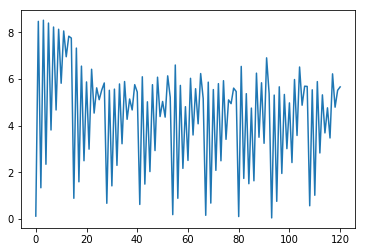

In [9]:
plt.plot(trainLoss)

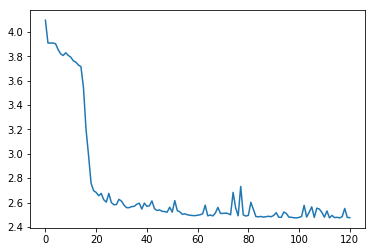

In [10]:
plt.plot(ValLoss)

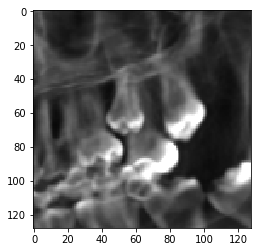

In [11]:
checkVal = 76
imshow(refPatches[checkVal][0].detach().cpu())

In [14]:
with torch.no_grad():
    noisyVal,refVal = noisyPatches[checkVal][0],refPatches[checkVal][0]
    noisyVal = noisyVal.cuda()
    refVal = refVal.cuda()
    output = net(noisyVal.unsqueeze(0))

F:\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


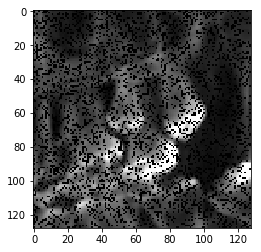

In [12]:
imshow(noisyPatches[checkVal][0].detach().cpu())

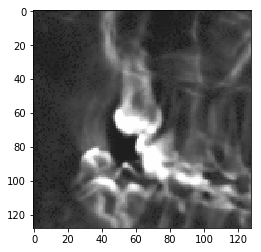

In [16]:
imshow(output.squeeze(0).detach().cpu())

### Encoder-Decoder

In [74]:
import torch.nn as nn
import torch.nn.functional as F


class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.enc1 = nn.Conv2d(3, 64, 3,stride=2, padding=1)
        self.enc2 = nn.Conv2d(64, 128, 3,stride=2, padding=1)
        self.enc3 = nn.Conv2d(128, 256, 3,stride=2, padding=1)
        self.enc4 = nn.Conv2d(256, 512, 3,stride=2, padding=1)
        self.enc5 = nn.Conv2d(512, 1024, 3,stride=2, padding=1)
        
        self.denc5 = nn.ConvTranspose2d(1024, 512, 4,stride=2, padding=1)
        self.denc4 = nn.ConvTranspose2d(512, 256, 4,stride=2, padding=1)
        self.denc3 = nn.ConvTranspose2d(256, 128, 4,stride=2, padding=1)
        self.denc2 = nn.ConvTranspose2d(128, 64, 4,stride=2, padding=1)
        self.denc1 = nn.ConvTranspose2d(64, 3, 4,stride=2, padding=1)
        
        self.out = nn.Conv2d(3, 3, 3,stride=1, padding=1)
          
    def forward(self, x):
        
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(x1)) 
        x3 = F.relu(self.enc3(x2)) 
        x4 = F.relu(self.enc4(x3)) 
        x5 = F.relu(self.enc5(x4))
        
        y5 = F.relu(self.denc5(x5))
        y5 = y5 + x4
        y4 = F.relu(self.denc4(y5))
        y4 = y4 + x3
        y3 = F.relu(self.denc3(y4))
        y3 = y3 + x2
        y2 = F.relu(self.denc2(y3))
        y2 = y2 + x1 
        y1 = F.relu(self.denc1(y2))
        y1 = y1 + x
        x6 = F.tanh(self.out(y1))
        return x6

In [75]:
net = Net4()
net = net.cuda()
criterion = torch.nn.L1Loss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [76]:
NO_OF_EPOCH = 65
trainLoss = []
ValLoss = []
totalIter = 0
lowestValLoss = 9999
for _ in range(NO_OF_EPOCH):
    shuffle(Train)
    totalTrainingLoss = 0.0
    for trainIndex in Train:
        noisy,ref = noisyPatches[trainIndex][0],refPatches[trainIndex][0]
        
        noisy = noisy.cuda()
        ref = ref.cuda()

        optimizer.zero_grad()
        output = net(noisy.unsqueeze(0))
        loss = criterion(output, ref.unsqueeze(0))
        loss.backward()
        optimizer.step()
        totalTrainingLoss +=loss.item()
        if(totalIter%50 == 0):
            trainLoss.append(totalTrainingLoss)
            totalTrainingLoss = 0
            with torch.no_grad():
                totalValLoss = 0.0
                for valIndex in Val:
                    noisyVal,refVal = noisyPatches[valIndex][0],refPatches[valIndex][0]
                    noisyVal = noisyVal.cuda()
                    refVal = refVal.cuda()
                    output = net(noisyVal.unsqueeze(0))
                    totalValLoss += criterion(output, refVal.unsqueeze(0))
                if(lowestValLoss>totalValLoss):
                    lowestValLoss = totalValLoss
                    torch.save(net, ".//SavedModel//InterModel//model_"+str(lowestValLoss.item())+".pth")
                    torch.save(net, ".//SavedModel//model_Best.pth")
                print("TotalIter:"+str(totalIter)+"TotalLoss:"+str(totalValLoss.item()))
                ValLoss.append(totalValLoss.item())
        totalIter +=1

F:\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
F:\Anaconda\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


TotalIter:0TotalLoss:20.980131149291992
TotalIter:50TotalLoss:8.34774398803711
TotalIter:100TotalLoss:5.296604156494141
TotalIter:150TotalLoss:4.60357666015625
TotalIter:200TotalLoss:4.219414710998535
TotalIter:250TotalLoss:3.7927942276000977
TotalIter:300TotalLoss:3.9714860916137695
TotalIter:350TotalLoss:3.2679014205932617
TotalIter:400TotalLoss:3.039579153060913
TotalIter:450TotalLoss:2.906562328338623
TotalIter:500TotalLoss:2.850027084350586
TotalIter:550TotalLoss:2.7061498165130615
TotalIter:600TotalLoss:2.6267313957214355
TotalIter:650TotalLoss:2.5562164783477783
TotalIter:700TotalLoss:2.4368784427642822
TotalIter:750TotalLoss:2.372926950454712
TotalIter:800TotalLoss:2.3468801975250244
TotalIter:850TotalLoss:3.054661512374878
TotalIter:900TotalLoss:2.283174991607666
TotalIter:950TotalLoss:2.1525721549987793
TotalIter:1000TotalLoss:2.0843796730041504
TotalIter:1050TotalLoss:2.030927896499634
TotalIter:1100TotalLoss:1.9602164030075073
TotalIter:1150TotalLoss:1.92410147190094
TotalI

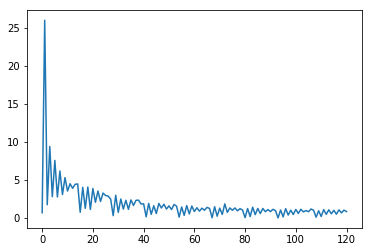

In [77]:
plt.plot(trainLoss)

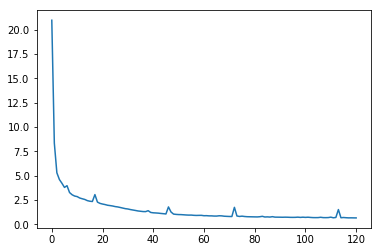

In [78]:
plt.plot(ValLoss)

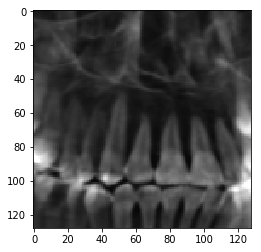

In [83]:
checkVal = 46
imshow(refPatches[checkVal][0].detach().cpu())

In [84]:
with torch.no_grad():
    noisyVal,refVal = noisyPatches[checkVal][0],refPatches[checkVal][0]
    noisyVal = noisyVal.cuda()
    refVal = refVal.cuda()
    output = net(noisyVal.unsqueeze(0))

F:\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


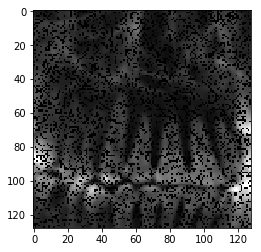

In [85]:
imshow(noisyPatches[checkVal][0].detach().cpu())

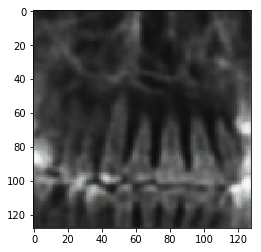

In [86]:
imshow(output.squeeze(0).detach().cpu())

In [87]:
patchTransform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

fullRes_Noisy = datasets.ImageFolder(".//Noisy_Small",patchTransform)
fullRes_Ref = datasets.ImageFolder(".//Ref_Small",patchTransform)

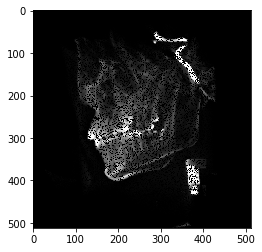

In [88]:
checkVal = 46
imshow(fullRes_Noisy[checkVal][0].detach().cpu())

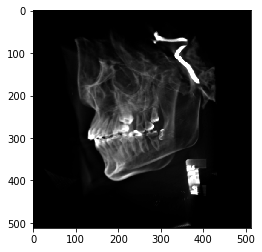

In [89]:
imshow(fullRes_Ref[checkVal][0].detach().cpu())

In [91]:
with torch.no_grad():
    output = net(fullRes_Noisy[checkVal][0].cuda().unsqueeze(0))

F:\Anaconda\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


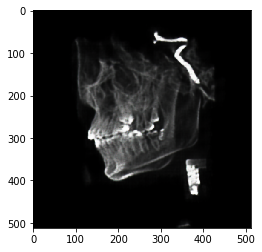

In [92]:
imshow(output.squeeze(0).detach().cpu())